## volumetric rate model

The total (integrated) Iax rate should be 20% of the SN Ia rate at z = 0. The rate should change with redshift following the star formation rate, as these are a young population of supernovae.

## luminosity function

The absolute V band magnitude should be sampled from this distribution.

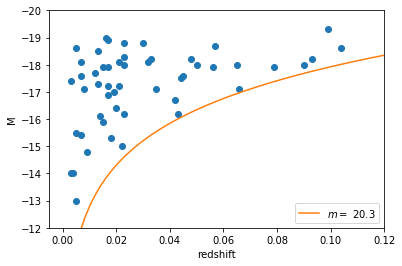

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(4)

sn, host, refs = np.genfromtxt('jha2017-table1.csv', delimiter=',',skip_header=1,
                             dtype='unicode',unpack=True,usecols=(0,1,4))
z, M = np.genfromtxt('jha2017-table1.csv', delimiter=',',skip_header=1,
                             unpack=True,usecols=(2,3))

plt.plot(z,M,marker='o',linestyle="None")
plt.ylim(-12,-20)
plt.xlim(-0.005,0.12)
plt.xlabel('redshift')
plt.ylabel('M')

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(H0=73.0, Om0=0.3)
zz = np.linspace(0.001,0.15,100)
mu = 5.0 * np.log10(cosmo.luminosity_distance(zz)/u.Mpc) + 25.0

mlim = 20.3
plt.plot(zz,mlim-mu,label=r"$m =$ " + "{:.1f}".format(mlim))
plt.legend(loc="lower right")
plt.show()

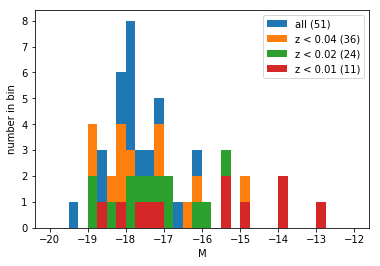

In [163]:
z1 = (z < 0.01)
z2 = (z < 0.02)
z4 = (z < 0.04)

n, b, p = plt.hist(M,label='all ({:d})'.format(len(M)),bins=32,range=[-20,-12])
plt.hist(M[z4],label='z < 0.04 ({:d})'.format(sum(z4)),bins=b)
plt.hist(M[z2],label='z < 0.02 ({:d})'.format(sum(z2)),bins=b)
plt.hist(M[z1],label='z < 0.01 ({:d})'.format(sum(z1)),bins=b)
plt.legend()
plt.xlabel('M')
plt.ylabel('number in bin')
plt.show()

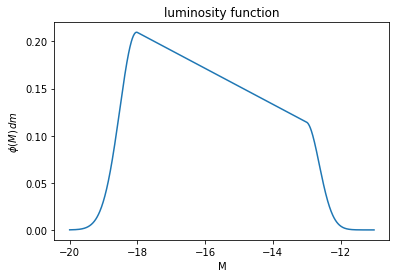

In [164]:
dx = 0.01
x = np.arange(-20,-11,dx)
nx = len(x)

# we approximate the luminosity function as linear, with
# Gaussian rolloffs at either end

# bright end rolloff
brightroll = -18.0
brightsig = 0.5

# faint end rolloff
faintroll = -13.0
faintsig = 0.4

# linear part
y = -(x+13.0)/6.0 + 1.0
#y = (x+19.0)/6.0 + 1.0
#y = np.ones(nx)

lx = (x < brightroll)
y[lx] *= np.exp(-(x[lx]-brightroll)**2/2.0/brightsig**2)
rx = (x > faintroll)
y[rx] *= np.exp(-(x[rx]-faintroll)**2/2.0/faintsig**2)
y /= np.sum(y)*dx

plt.plot(x,y)
plt.title('luminosity function')
plt.xlabel('M')
plt.ylabel(r'$\phi(M)\,dm$')
plt.show()

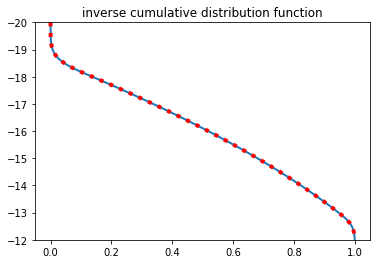

In [165]:
# to sample from this luminosity function 
# we calculate the cumulative distribution function
# and invert it via linear interpolation

cdf = np.cumsum(y)*dx
uy = np.arange(0,1,0.0001)
invcdf = np.interp(uy,cdf,x)

# plot it up and compare the interpolation
plt.plot(uy,invcdf,linewidth=2)
plt.plot(cdf,x,linestyle=':',linewidth=4,color='r')
plt.ylim(-12,-20)
plt.title('inverse cumulative distribution function')
plt.show()

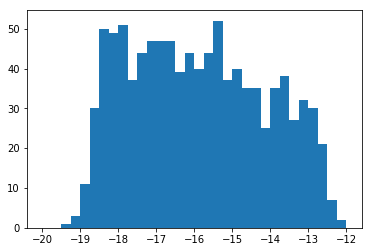

fraction brighter than -17.5:  0.232


In [166]:
# once we have the invcdf we can just interpolate it
# with random uniform deviates to get our samples
ssize = 1000
unif = np.random.random(size=ssize)
Msamp = np.interp(unif,uy,invcdf)

plt.hist(Msamp,bins=32,range=[-20,-12])
plt.show()

print("fraction brighter than -17.5: ",sum(Msamp < -17.5)/len(Msamp))

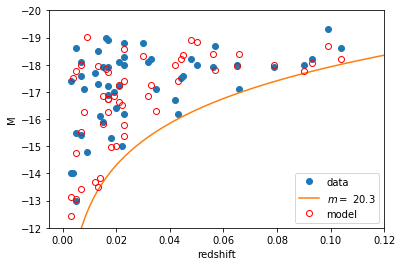

In [167]:
Mmodel = np.zeros(len(M))
muz = 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0

for i in range(len(M)):
    while True:
        iM = np.interp(np.random.random(),uy,invcdf)
        ms = iM + muz[i]
        if ms < mlim:
            break
    Mmodel[i] = iM
    
plt.plot(z,M,marker='o',linestyle="None",label='data')
plt.ylim(-12,-20)
plt.xlim(-0.005,0.12)
plt.xlabel('redshift')
plt.ylabel('M')
plt.plot(zz,mlim-mu,label=r"$m =$ " + "{:.1f}".format(mlim))
plt.plot(z,Mmodel,marker='o',linestyle="none", color='r',
        fillstyle="none",label='model')
plt.legend(loc="lower right")
plt.show()

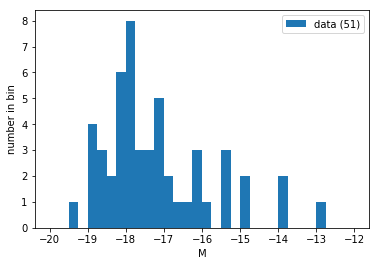

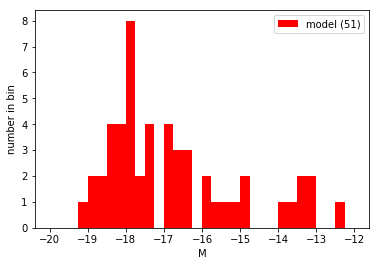

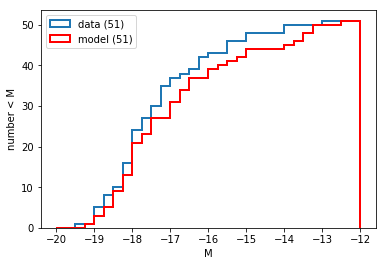

KS probability: 0.251
Anderson-Darling probability: 0.291


/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/morestats.py:1676: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [168]:
# do histogram version of the above
n, b, p = plt.hist(M,label='data ({:d})'.format(len(M)),bins=32,range=[-20,-12])
plt.legend()
plt.xlabel('M')
plt.ylabel('number in bin')
plt.show()

plt.hist(Mmodel,bins=b,label='model ({:d})'.format(len(Mmodel)),color='r')
plt.legend()
plt.xlabel('M')
plt.ylabel('number in bin')
plt.show()

plt.hist(M,bins=b,label='data ({:d})'.format(len(M)),
         cumulative=True,histtype='step',lw=2)
plt.hist(Mmodel,bins=b,label='model ({:d})'.format(len(Mmodel)),color='r',
         cumulative=True,histtype='step',lw=2)
plt.legend(loc='upper left')
plt.xlabel('M')
plt.ylabel('number < M')
plt.show()

from scipy.stats import ks_2samp, anderson_ksamp
ks, ksp = ks_2samp(M,Mmodel)
print("KS probability: {:.3f}".format(ksp))

ad, adcv, adp = anderson_ksamp([M,Mmodel])
print("Anderson-Darling probability: {:.3f}".format(adp))

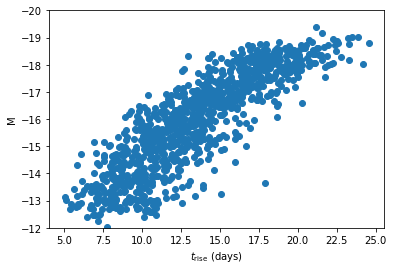

In [169]:
# given peak magnitude, estimate rise time from Magee et al. (2016, A&A, 589, A89)
# 3 mag = 10 days
trise = 21 - (Msamp + 19)*10/3.0 + 0.22*(Msamp + 19)**2 + np.random.normal(size=len(Msamp))*2.0

plt.scatter(trise,Msamp)
plt.xlabel(r'$t_{\rm rise}$ (days)')
plt.ylabel(r'M')
plt.ylim(-12,-20)
plt.show()

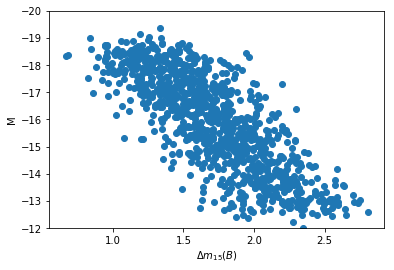

In [170]:
# estimate dm15(B)
dm15B = 1.2 + (Msamp + 19)/6.0 + np.random.normal(size=len(Msamp))*0.25

plt.scatter(dm15B,Msamp)
plt.ylim(-12,-20)
plt.xlabel(r'$\Delta m_{15}(B)$')
plt.ylabel(r'M')
plt.show()

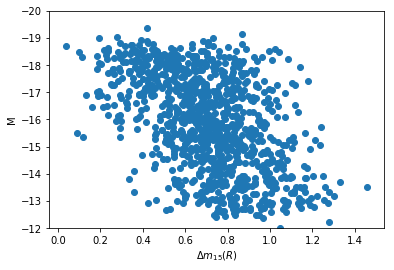

In [171]:
# estimate dm15(R)
dm15R = np.abs(0.5 + (Msamp + 19)/15.0 + np.random.normal(size=len(Msamp))*0.2)

plt.scatter(dm15R,Msamp)
plt.ylim(-12,-20)
plt.xlabel(r'$\Delta m_{15}(R)$')
plt.ylabel(r'M')
plt.show()

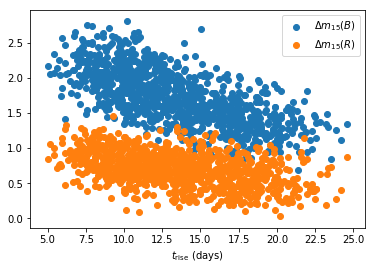

In [172]:
plt.scatter(trise,dm15B,label=r'$\Delta m_{15}(B)$')
plt.scatter(trise,dm15R,label=r'$\Delta m_{15}(R)$')
plt.xlabel(r'$t_{\rm rise}$ (days)')
plt.legend()
plt.show()

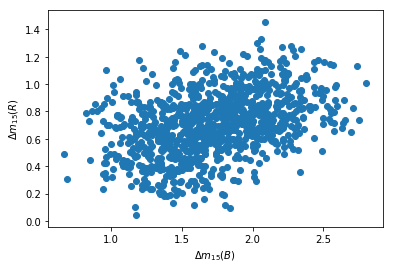

In [173]:
plt.scatter(dm15B,dm15R)
plt.xlabel(r'$\Delta m_{15}(B)$')
plt.ylabel(r'$\Delta m_{15}(R)$')
plt.show()

In [174]:
import pickle
import sncosmo
source = pickle.load(open('SN2005hk/sn2005hk.source.pickle', "rb" ), encoding="latin-1" )['source']
sedmodel = sncosmo.Model(source=source)

sedVmag = sedmodel.bandmag('bessellv','vega',0.0)
print(sedVmag)

15.7692642401


-17.6163181481


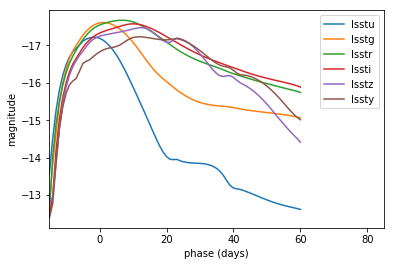

In [189]:
amplitudes = 10.0**(-0.4*(Msamp - sedVmag))

filters = ['lsstu','lsstg','lsstr','lssti','lsstz','lssty']
phase = np.linspace(-15.,60.,76)

ref = 5

print(Msamp[ref])
sedmodel.set(amplitude=amplitudes[ref])

plt.plot()
for f in filters:
    band = sncosmo.get_bandpass(f)
    sedmag = sedmodel.bandmag(band,'ab',phase)
    plt.plot(phase,sedmag,label=f)
plt.xlim(-15,85)
plt.ylim(plt.ylim()[::-1])
plt.xlabel('phase (days)')
plt.ylabel('magnitude')
plt.legend()
plt.show()

18.1048539309


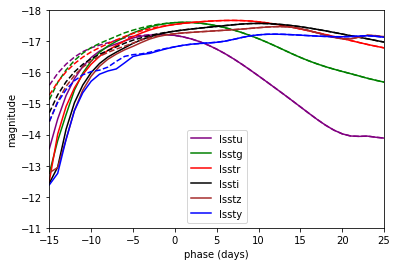

In [190]:
wave = np.linspace(1000.,25000.,2401)
flux = sedmodel.flux(phase,wave)

# stretch pre-max SED to give correct trise
print(trise[ref])
premax = np.where(phase < 0.)
newphase = np.copy(phase)
newphase[premax] *= -trise[ref]/np.min(phase)
newphase = np.insert(newphase,0,newphase[0]-1.0)
newflux = np.append(flux[[0],:]/100.,flux,axis=0)

newmodel = sncosmo.TimeSeriesSource(newphase,wave,newflux)

colors = ['purple','green','red','black','brown','blue']

plt.plot()
for f,c in zip(filters, colors):
    band = sncosmo.get_bandpass(f)
    plt.plot(phase,sedmodel.bandmag(band,'ab',phase),label=f,color=c)
    plt.plot(phase,newmodel.bandmag(band,'ab',phase),'--',color=c)
plt.xlim(-15,25)
plt.ylim(-11,-18)
plt.xlabel('phase (days)')
plt.ylabel('magnitude')
plt.legend()
plt.show()

1.61714453848
1.17206161049
(77, 2401)


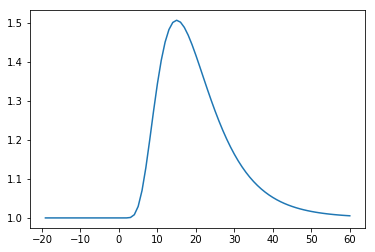

(77,)
1.17206161049


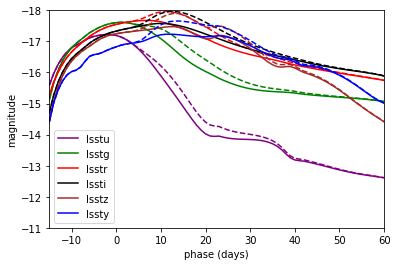

In [191]:
seddm15B = newmodel.bandmag('bessellb','vega',15.0) - newmodel.bandmag('bessellb','vega',0.0)
print(seddm15B)

postmax = np.where(newphase > 0.)
flux = newmodel.flux(newphase,wave)
print(dm15B[ref])

print(flux.shape)
sc = 10.0**(-0.4*(dm15B[ref] - seddm15B))

mult = np.ones_like(newphase)
postmax = np.where(newphase > 1.0)
mult[postmax] = 1.0 + (sc - 1.0)*np.exp(-((np.log10(newphase[postmax]) 
                                           - np.log10(15.0))**2/2.0/0.2**2))
plt.plot(newphase,mult)
plt.show()
print(mult.shape)

scflux = flux * mult[:,None]

scmodel = sncosmo.TimeSeriesSource(newphase,wave,scflux)
scdm15B = scmodel.bandmag('bessellb','vega',15.0) - scmodel.bandmag('bessellb','vega',0.0)
print(scdm15B)

plt.plot()
for f,c in zip(filters, colors):
    band = sncosmo.get_bandpass(f)
    plt.plot(phase,newmodel.bandmag(band,'ab',phase),label=f,color=c)
    plt.plot(phase,scmodel.bandmag(band,'ab',phase),'--',color=c)
plt.xlim(-15,60)
plt.ylim(-11,-18)
plt.xlabel('phase (days)')
plt.ylabel('magnitude')
plt.legend()
plt.show()

-0.326463013874
0.867434754605
(5, 77)


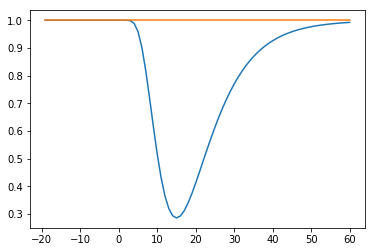

(77,) (5,)
(77, 2401)
1.17206161049 1.1765209694 1.17206161049
-0.326463013874 0.863718882167 0.867434754605


In [192]:
scdm15R = scmodel.bandmag('bessellr','vega',15.0) - scmodel.bandmag('bessellr','vega',0.0)
print(scdm15R)
print(dm15R[ref])
scR = 10.0**(-0.4*(dm15R[ref] - scdm15R))

multB = np.ones_like(newphase)
multR = np.ones_like(newphase)
postmax = np.where(newphase > 1.0)
multR[postmax] = 1.0 + (scR - 1.0)*1.07*np.exp(-((np.log10(newphase[postmax]) 
                                           - np.log10(15.0))**2/2.0/0.2**2))


wx = np.array([2350., 5200., 6000., 8350., 10350.])
mm = np.array([multB, multB, multR, multR, multR])
print(mm.shape)
plt.plot(newphase,multR)
plt.plot(newphase,multB)
plt.show()

print(newphase.shape,wx.shape)

from scipy import interpolate
f = interpolate.interp2d(newphase,wx,mm)
nmult = np.transpose(f(newphase,wave))
print(nmult.shape)

outflux = scflux * nmult
outmodel = sncosmo.TimeSeriesSource(newphase,wave,outflux)
outdm15B = outmodel.bandmag('bessellb','vega',15.0) - outmodel.bandmag('bessellb','vega',0.0)
print(scdm15B,outdm15B,dm15B[ref])

outdm15R = outmodel.bandmag('bessellr','vega',15.0) - outmodel.bandmag('bessellr','vega',0.0)
print(scdm15R,outdm15R,dm15R[ref])

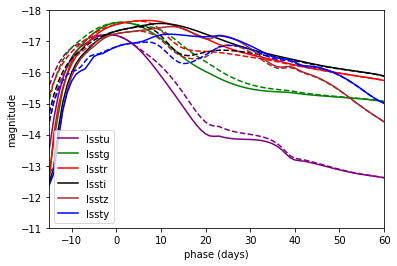

In [193]:
plt.plot()
for f,c in zip(filters, colors):
    band = sncosmo.get_bandpass(f)
    plt.plot(phase,sedmodel.bandmag(band,'ab',phase),label=f,color=c)
    plt.plot(phase,outmodel.bandmag(band,'ab',phase),'--',color=c)
plt.xlim(-15,60)
plt.ylim(-11,-18)
plt.xlabel('phase (days)')
plt.ylabel('magnitude')
plt.legend()
plt.show()


In [194]:
from astropy.table import Table

